## Modelling
### Layout:
1. Data Retrieval and cleaning
2. Feature Selection
3. Normalization of the features
4. Splitting data into Train and test sets
5. Plugging the data into models


In [ ]:
#Install the required Packages
!pip install xgboost
!pip install graphviz
!pip install tabulate
!pip install scipy

In [ ]:
#import the libraries
#standard python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost


# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from xgboost import plot_tree

# Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import seaborn as sns

# Miscellaneous
from tabulate import tabulate

## 1) Importing the Data and Extracting the required columns
### Dataset :
1. Health Survey for England (HSE) : Acquired from the NHS

In [ ]:
#Reading the dataset
df = pd.read_stata("hse_2018_eul_15082022.dta",convert_categoricals=False)
df.head(5)

,Seriala,HSEYr,SampType,FinOutc,hhsize6,Nofad3,Nofch3,Qrtint,intdayw,IndOut,...,PSU_SCR,Cluster195,Cluster95,Cluster48,wt_int,wt_nurse,wt_sc,wt_probgam,wt_blood,wt_cotinine
0,2811527,2018,1,110,1,1,0,1,6,110,...,2181505,218211,218105,218706,0.827608,0.704973,0.763393,0.781099,0.787373,NaN
1,2804238,2018,1,110,1,1,0,1,5,110,...,2181505,218211,218105,218706,0.807912,0.655432,0.741788,0.779406,0.615612,NaN
2,2808193,2018,1,110,2,2,0,1,2,110,...,2181505,218211,218105,218706,1.084289,0.868472,1.098222,1.164414,NaN,NaN
3,2807643,2018,1,110,2,2,0,1,2,110,...,2181505,218211,218105,218706,0.961400,0.786779,0.896711,0.995665,NaN,NaN
4,2803796,2018,1,110,3,2,1,1,3,110,...,2181505,218211,218105,218706,1.203303,1.120884,1.118913,1.106583,1.144427,NaN


## 2) Feature Selection

In [ ]:
# Passing the feature names to be extracted
feature_names = ["Sex","age16g5","drinkYN","GHQWORTH","topqual3","Anyacty","cigst1"]

In [ ]:
# filtering the data for the features passed
df = df.loc[:,feature_names]
df.head(3)

,Sex,age16g5,drinkYN,GHQWORTH,topqual3,Anyacty,cigst1
0,2,12,1,1,2,1,4
1,1,12,2,1,1,2,3
2,1,11,1,2,2,2,3


## 3) Nomalizing and scaling the features

In [ ]:
# Renaming all the columns to have meaningful names and specifying range of values for allm these categorical variables
df = df.rename(columns={"age16g5":"age_group","GHQWORTH":"Self worth","drinkYN":"Alcoholism","cigst1":"smoking status","topqual3":"Top_qualification","Anyacty":"Gambling"})

df = df[df["Sex"].isin([1,2])]
df = df[df["age_group"].isin([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])]

df = df[df["Self worth"].isin([1,2,3,4])]
df = df[df["smoking status"].isin([1,2,3,4])]
df = df[df["Alcoholism"].isin([1,2])]
df = df[df["Top_qualification"].isin([1,2,3,4,5,6,7])]
df = df[df["Gambling"].isin([1,2])]

# Setting Gambling status to values 0 or 1
df['Gambling'] = df['Gambling'].replace({2.0: 0, 1.0: 1})
df.reset_index(drop=True, inplace=True)
df.head(3)

,Sex,age_group,Alcoholism,Self worth,Top_qualification,Gambling,smoking status
0,2,12,1,1,2,1,4
1,1,12,2,1,1,0,3
2,1,11,1,2,2,0,3


### Feature Ranking Using Kbest Scoring
It is a technique used in machine learning to select the top k features that are most important for predicting the target variable.

The process involves ranking all the features in the dataset according to their scores and selecting the top k features with the highest scores. The scores are calculated using a scoring function that measures the relevance of each feature to the target variable.

In [ ]:
# separate the features and the output variable
X = df.drop('Gambling', axis=1)
y = df['Gambling']

# instantiate the SelectKBest class and specify the score function
selector = SelectKBest(score_func=f_regression, k=X.shape[1])

# fit the selector to your data
selector.fit(X, y)

# get the scores of all features
scores = selector.scores_

# get the names of all features
features = X.columns

# create a dictionary of feature names and scores
score_dict = dict(zip(features, scores))

# get the input features and their scores
input_features = ['Sex', 'age_group','Alcoholism','Self worth','Top_qualification','smoking status']
#,'Ethnicity'
input_scores = [score_dict[feature] for feature in input_features]

# create a dataframe of input features and their scores
input_df = pd.DataFrame({'Feature': input_features, 'Score': input_scores})

# sort the dataframe by score in descending order
input_df = input_df.sort_values('Score', ascending=False)

# get the ranks of the input features
ranks = [input_df[input_df['Feature'] == feature].index[0]+1 for feature in input_features]

# print the ranks of the input features
for i, feature in enumerate(input_features):
    print(f"{feature} ranks {ranks[i]} out of {len(features)} features.")

Sex ranks 1 out of 6 features.
age_group ranks 2 out of 6 features.
Alcoholism ranks 3 out of 6 features.
Self worth ranks 4 out of 6 features.
Top_qualification ranks 5 out of 6 features.
smoking status ranks 6 out of 6 features.


## 4) Splitting the Data into train and test sets

In [ ]:
# Split the data into input features and the output feature
y = df["Gambling"]
X = df.drop(columns="Gambling")

In [ ]:
# Splitting the data into Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

## 5) Modelling

### 5.1) MLP Classifier

In [ ]:
#defining the model and it's parameters
clf = MLPClassifier(hidden_layer_sizes=(100,50), activation= "relu", solver = "adam", random_state = 1)

Parameter values:
hidden_layer_sizes : no. of neurons in the ith hidden layer (100 in the first and 50 in the 2nd)

activation: activation function, 'relu' by default, it's use helps to prevent the exponential growth in the computation required to operate the neural network

solver: solver for weight optimization, adam’ works pretty well on relatively large datasets in terms of both training time and validation score

random_state : Determines random number generation for weights and bias initialization, for reproducible results

In [ ]:
# fitting a Multi-layer Perceptron (MLP) classifier to the training data.
MLP_model = clf.fit(X_train,y_train)

In [ ]:
# assigning the target variable of the test dataset to the variable "expected_y"
expected_y = y_test
# using the trained MLP model, represented by the variable "MLP_model", to make predictions on the test dataset, represented by the input features X_test. 
predicted_y = MLP_model.predict(X_test)

In [ ]:
# print the classification report for the MLP
print(f"Classification report for classifier {MLP_model}:\n"
      f"{metrics.classification_report(expected_y,predicted_y)}\n")

Classification report for classifier MLPClassifier(hidden_layer_sizes=(100, 50), random_state=1):
              precision    recall  f1-score   support

           0       0.65      0.39      0.49       928
           1       0.63      0.83      0.72      1179

    accuracy                           0.64      2107
   macro avg       0.64      0.61      0.60      2107
weighted avg       0.64      0.64      0.62      2107




In [ ]:
# Mean Accuracy score
mlp_score = clf.score(X_test, y_test)
print("MLP mean accracy", mlp_score)

MLP mean accracy 0.6383483626008543


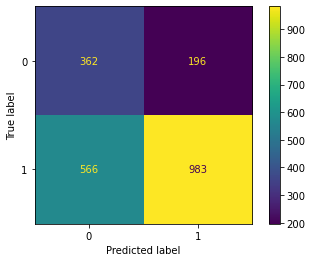

In [ ]:
# Producing the Confusion matrix to calculate how many predictions are correct and incorrect per class
cm = metrics.ConfusionMatrixDisplay.from_predictions(predicted_y,expected_y)
plt.show()

### Hyperparameter tuning for MLP

In [ ]:
# Import Random Search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


# Need to create a dictionary of parameters that need optimizing
parameters = {'activation': ["identity","logistic","tanh","relu"],
              'solver' : ["lbfgs","sgd","adam"],
              'alpha' : uniform(loc=0,scale=1)}

# Use Random Search with the model and parameters defined
rand = RandomizedSearchCV(estimator=clf,
                param_distributions=parameters,
                n_iter=5,
                cv=10,
                n_jobs = -1)

# Fit random search model on training data
rand.fit(X_train,y_train)


print(rand.best_params_)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

{'activation': 'tanh', 'alpha': 0.8131456774365075, 'solver': 'adam'}


In [ ]:
# calculating accuracy after tuning
from sklearn.model_selection import cross_val_score

MLP_new = MLPClassifier(activation="relu",alpha=0.47337823045279126,solver="adam")

score = np.mean(cross_val_score(MLP_new,X,y,cv=10,scoring="accuracy"))

print("MLP score after tuning: ")
print(score)

MLP score after tuning: 
0.6235589840852999


## 5.2) Random forest Classifier

In [ ]:
#defining the model and it's parameters
random_forest = RandomForestClassifier(n_estimators=5, max_depth=2, criterion="gini", random_state =1)
random_forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=2, n_estimators=5, random_state=1)

Parameters:

n_estimators : no. of trees in the forest

criterion: function to measure the quality of a split

max_depth: max depth of tree

In [ ]:
# using a trained Random Forest classifier model, represented by the variable "random_forest", to make predictions on the test dataset represented by the input features X_test.
y_pred = random_forest.predict(X_test)

In [ ]:
# calcualting acuracy of RFC
rf_accuracy = accuracy_score(y_test, y_pred)
print("Accuracy for random forest:", rf_accuracy)

Accuracy for random forest: 0.6127195064072141


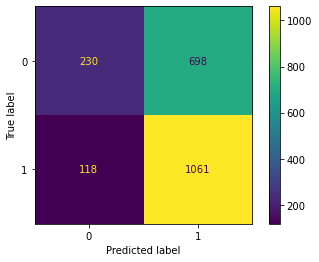

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();


Alcoholism           0.452142
Top_qualification    0.263430
age_group            0.170426
smoking status       0.064107
Self worth           0.049894
Sex                  0.000000
dtype: float64


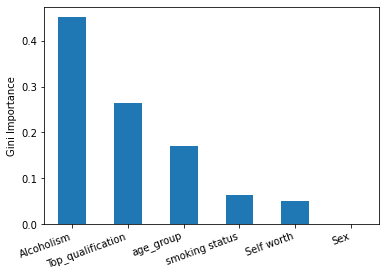

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(random_forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print(feature_importances)
# Plot a simple bar chart for displaying feature imporatnce score
feature_importances.plot.bar();
plt.ylabel('Gini Importance');
plt.xticks(rotation = 20,ha = 'right')
plt.show()

## 5.3) XGBOOST Classifier

In [ ]:
#defining the model and it's parameters
xgb = XGBClassifier(n_estimators=50, max_depth =2)

xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)

# accuracy calculation for XGBoost
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100


print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))


XGBoost's prediction accuracy is: 63.03


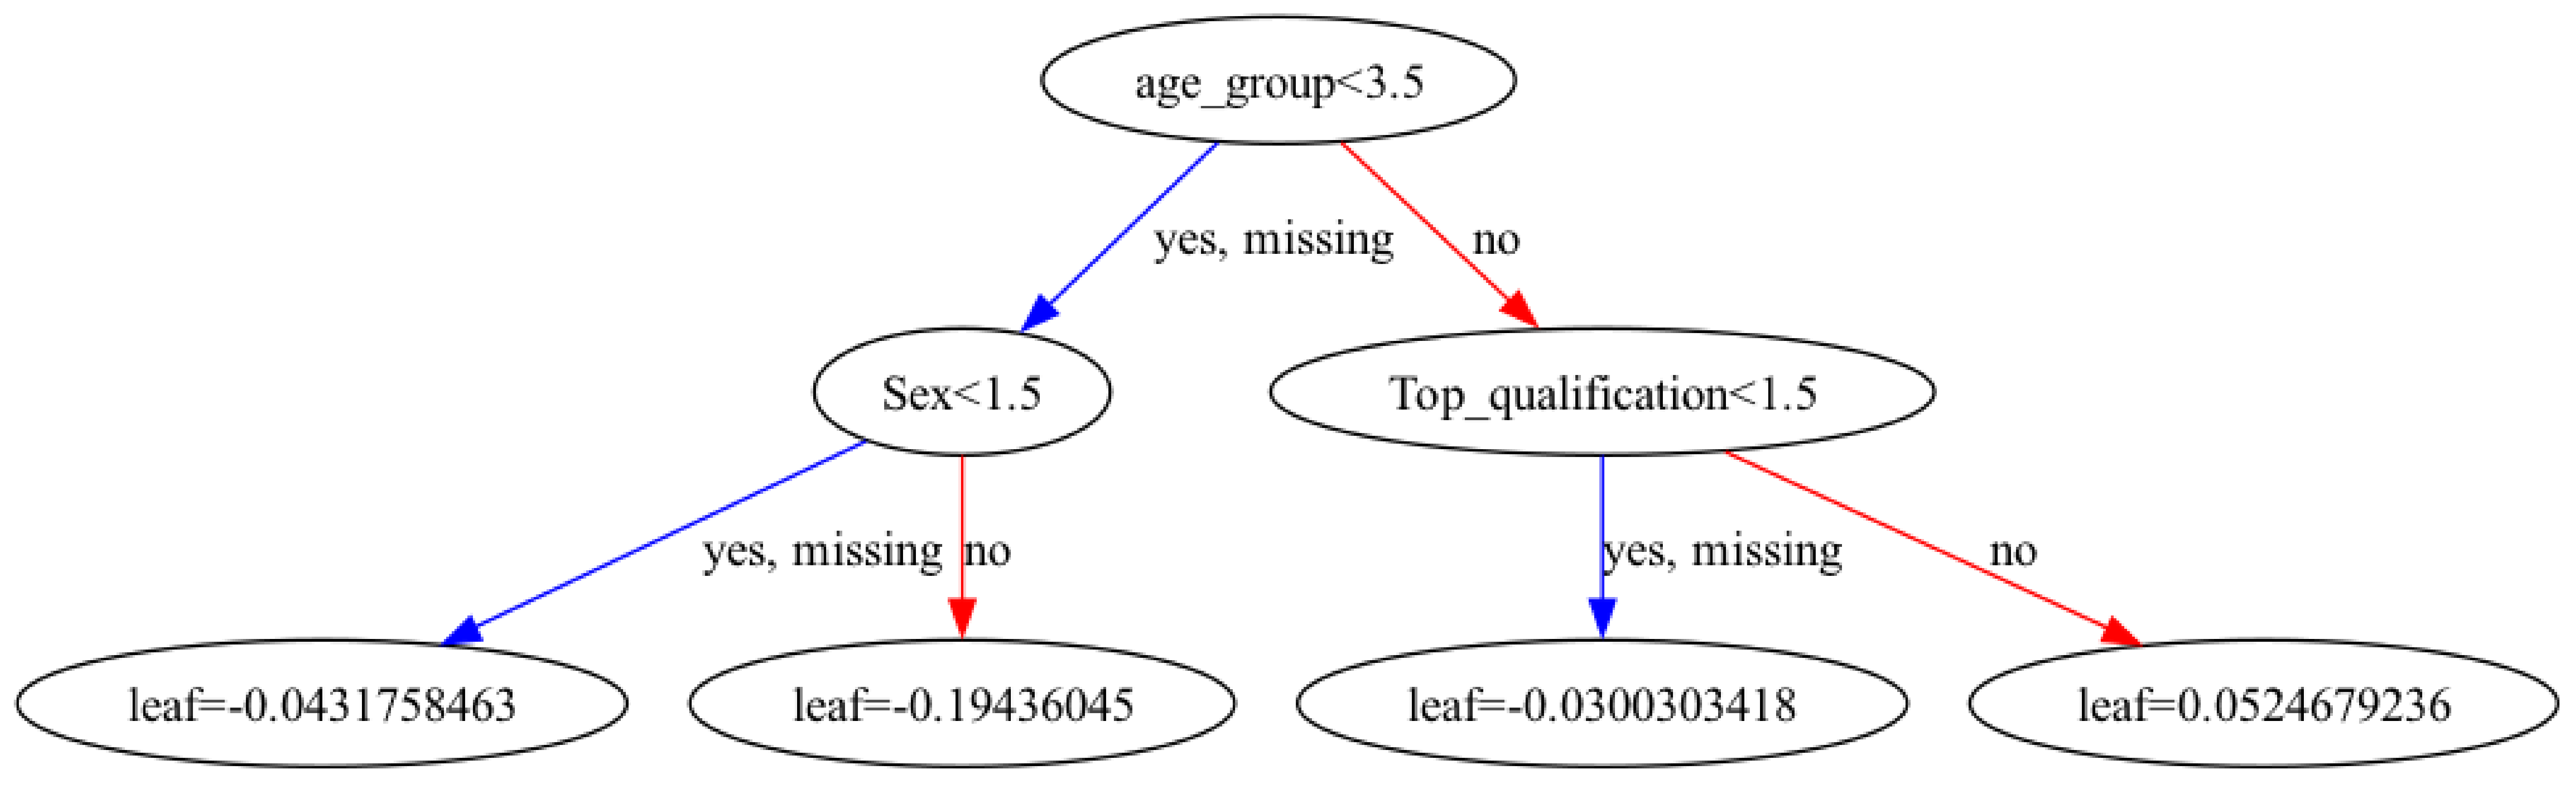

In [ ]:
# Visualizing one of the trees
fig, ax = plt.subplots(figsize=(100, 100))
plot_tree(xgb, num_trees=4, ax=ax)
plt.show()

In [ ]:
#Calculating feature importance scores 

importance_scores = xgb.feature_importances_

feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importance_scores})
feature_importances = feature_importances.sort_values(by='importance', ascending=False).reset_index(drop=True)
print(feature_importances)



             feature  importance
0         Alcoholism    0.645332
1          age_group    0.089572
2     smoking status    0.088506
3  Top_qualification    0.079814
4         Self worth    0.049186
5                Sex    0.047589


#### Reasoning :  xgb.feature_importances_ provides a measure of the relative importance of each feature in an XGBoost model, calculated based on the number of times each feature is used to split the data across all trees in the ensemble, weighted by the reduction in the objective function achieved by each split.

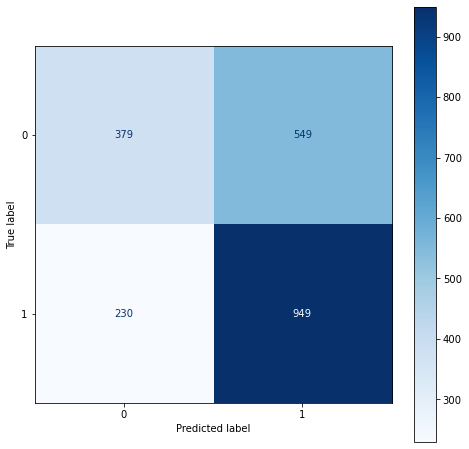

In [ ]:
y_pred = xgb.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
class_names = np.unique(y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot the matrix
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.show()

# Using Cross Validation for Random Forest and XGboost

By performing k-fold cross-validation, we can obtain a more accurate estimate of the performance of our model on unseen data

This way we can avoid overfitting to a particular split of the data and better use all of our available data for training and evaluation.

### Cross validation for random forest

In [ ]:
# we're testing performance for 10 different sets of test and train and then avergaing the performance
rfc_cv = RandomForestClassifier(n_estimators=5, max_depth=2, criterion="gini")
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.60365854 0.58943089 0.57520325 0.59552846 0.60692464 0.59674134
 0.58452138 0.61507128 0.57433809 0.6293279 ]
Mean: 0.5970745781795904
Standard Deviation: 0.016487400363226042


### Cross validation for XGBoost

In [ ]:
# we're testing performance for 10 different sets of test and train and then avergaing the performance

xgb_cv = XGBClassifier(n_estimators=50, max_depth =2)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")

print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.63414634 0.61788618 0.6097561  0.6199187  0.6191446  0.6191446
 0.6089613  0.6191446  0.60081466 0.64154786]
Mean: 0.6190464954547712
Standard Deviation: 0.011211043855789114


# Using SVM (Support vector Machine) for Classification

In [ ]:
#defining the model
svc = SVC(kernel='rbf', C=1.5, gamma='scale')


parameters:

kernel: This parameter specifies the kernel function to be used by the SVC algorithm.

C: This parameter controls the regularization strength. A smaller value of C creates a wider margin, allowing more misclassifications, while a larger value of C creates a narrower margin, potentially overfitting the data.

gamma: This parameter controls the shape of the decision boundary. A smaller value of gamma creates a smoother decision boundary, while a larger value of gamma creates a more complex boundary that can fit the training data more closely.

In [ ]:
#Prediction

svc.fit(X_train, y_train)

preds = svc.predict(X_test)

# calculating accuracy for SVM
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100


print("Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))


Support Vector Machine Classifier's prediction accuracy is: 62.98


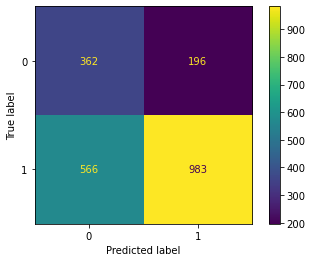

In [ ]:
#confusion matrix for SVM
cm = metrics.ConfusionMatrixDisplay.from_predictions(predicted_y,expected_y)
plt.show()

 # Comparison of all 4 Models

In [ ]:
# Create a list of tuples, where each tuple contains the model name and the corresponding accuracy score
data = [("Support Vector Machines", acc_svc),
        ("XGBoost", acc_xgb),
        ("Random Forest", rf_accuracy*100),
        ("Multi Layer perceptron", mlp_score*100)]

# Create a table from the data using the tabulate library
table = tabulate(data, headers=["Model", "Accuracy(%)"])

# Print the table
print(table)

Model                      Accuracy(%)
-----------------------  -------------
Support Vector Machines        62.9805
XGBoost                        63.028
Random Forest                  61.272
Multi Layer perceptron         63.8348


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d86a7c1f-f97f-4567-be95-57cd9e1ec63e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>